# data_d25a.ipynb
Produce the fusion, high-end, and low-end projections.

Author: Benjamin S. Grandey.

In [1]:
import d25a
import datetime
from matplotlib import pyplot as plt
import pandas as pd

In [2]:
# Get start datetime
start_dt = datetime.datetime.now()

In [3]:
# Print package versions
print(d25a.get_watermark())

Python implementation: CPython
Python version       : 3.10.16
IPython version      : 8.31.0

matplotlib: 3.10.0
numpy     : 2.2.1
pandas    : 2.2.3
seaborn   : 0.13.2
xarray    : 2024.11.0

conda environment: d25a-rsl-fusion

Compiler    : Clang 18.1.8 
OS          : Darwin
Release     : 22.6.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit



## Check that fusion results look reasonable

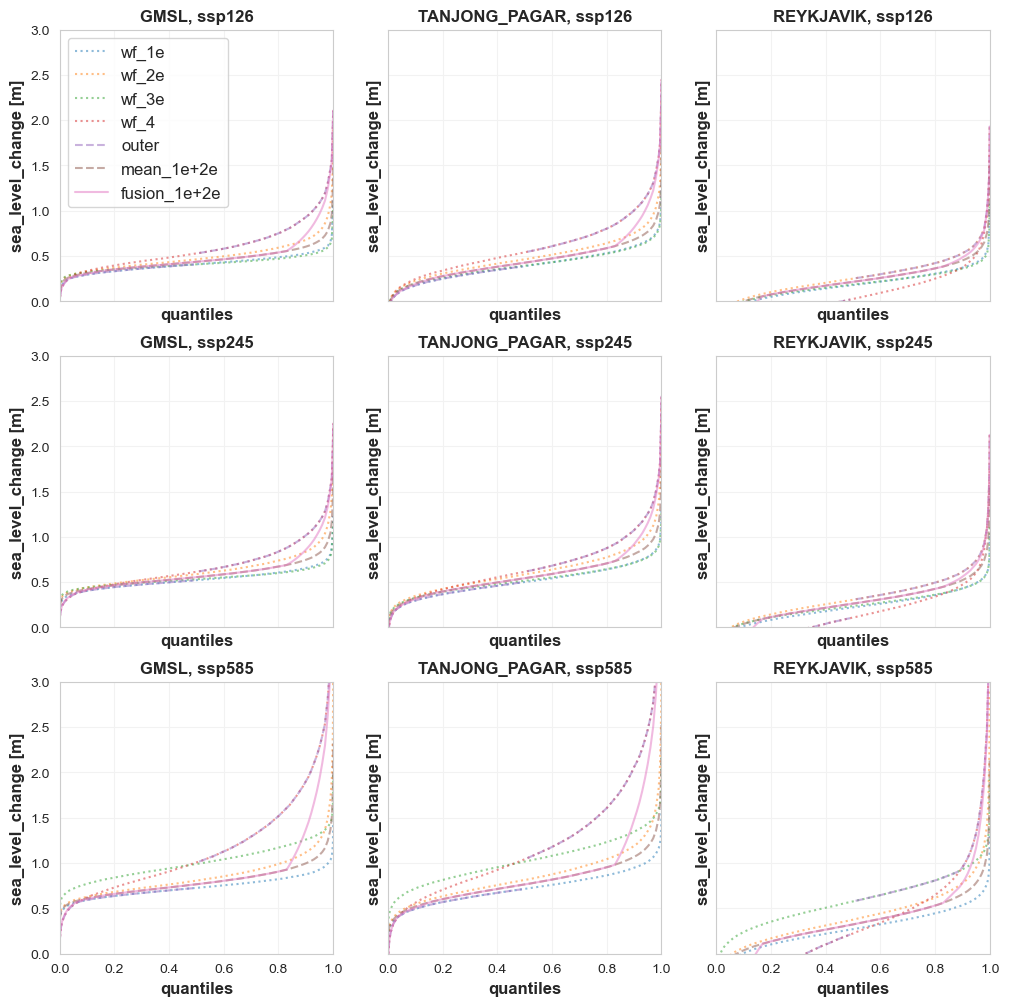

In [4]:
# Create subplot panels
fig, axs = plt.subplots(3, 3, figsize=(12, 12), sharex=True, sharey=True)
# Loop over locations, scenarios, and corresponding axes
for g, gauge in enumerate([None, 'TANJONG_PAGAR', 'REYKJAVIK']):
    for s, scenario in enumerate(['ssp126', 'ssp245', 'ssp585']):
        ax = axs[s, g]
        # Loop over workflows
        for workflow in ['wf_1e', 'wf_2e', 'wf_3e', 'wf_4', 'outer', 'mean_1e+2e', 'fusion_1e+2e']:
            # Get data for 2100
            if gauge:  # RSL
                qfs_da = d25a.get_sl_qfs(workflow=workflow, gmsl_rsl_novlm='rsl', scenario=scenario).sel(years=2100)
                qfs_da = qfs_da.sel(locations=d25a.get_gauge_info(gauge=gauge)['gauge_id'])
            else:  # GMSL
                qfs_da = d25a.get_sl_qfs(workflow=workflow, gmsl_rsl_novlm='gmsl', scenario=scenario).sel(years=2100)
            # Plot data
            if 'wf' in workflow:
                linestyle = ':'
            elif workflow == 'fusion_1e+2e':
                linestyle = '-'
            else:
                linestyle = '--'
            qfs_da.plot(ax=ax, linestyle=linestyle, alpha=0.5, label=workflow)
            # Customize title etc
            if gauge:
                ax.set_title(f'{gauge}, {scenario}')
            else:
                ax.set_title(f'GMSL, {scenario}')
            if g == 0 and s == 0:
                ax.legend()
            ax.set_xlim(0, 1)
            ax.set_ylim(0, 3)

## Save fusion, high-end, low-end, and central projections

In [5]:
# Make output directory if it doesn't exist
if not d25a.DATA_DIR.exists():
    d25a.DATA_DIR.mkdir()

In [6]:
# Loop over GMSL/RSL and scenarios
for gmsl_rsl_novlm in ('gmsl', 'rsl', 'novlm'):
    for scenario in ['ssp585', 'ssp126', 'ssp245']:
        # Derive fusion projection
        qfs_da = d25a.get_sl_qfs(workflow='fusion_1e+2e', gmsl_rsl_novlm=gmsl_rsl_novlm, scenario=scenario)
        # Drop locations with NaN
        if gmsl_rsl_novlm != 'gmsl':
            qfs_da = qfs_da.dropna(dim='locations')
        # Save fusion projection
        out_fn = d25a.DATA_DIR / f'{gmsl_rsl_novlm}_fusion_{scenario}_d25a.nc'
        print(f'Writing {out_fn.name}')
        qfs_da.to_netcdf(out_fn)
        # Derive and save high-end, low-end, or central projection, depending on scenario
        if scenario == 'ssp585':
            high_da = qfs_da.sel(quantiles=0.95).squeeze()
            out_fn = d25a.DATA_DIR / f'{gmsl_rsl_novlm}_high_d25a.nc'
            print(f'Writing {out_fn.name}')
            high_da.to_netcdf(out_fn)
        elif scenario == 'ssp126':
            low_da = qfs_da.sel(quantiles=0.05).squeeze()
            out_fn = d25a.DATA_DIR / f'{gmsl_rsl_novlm}_low_d25a.nc'
            print(f'Writing {out_fn.name}')
            low_da.to_netcdf(out_fn)
        elif scenario == 'ssp245':
            central_da = qfs_da.sel(quantiles=0.50).squeeze()
            out_fn = d25a.DATA_DIR / f'{gmsl_rsl_novlm}_central_d25a.nc'
            print(f'Writing {out_fn.name}')
            central_da.to_netcdf(out_fn)

Writing gmsl_fusion_ssp585_d25a.nc
Writing gmsl_high_d25a.nc
Writing gmsl_fusion_ssp126_d25a.nc
Writing gmsl_low_d25a.nc
Writing gmsl_fusion_ssp245_d25a.nc
Writing gmsl_central_d25a.nc
Writing rsl_fusion_ssp585_d25a.nc
Writing rsl_high_d25a.nc
Writing rsl_fusion_ssp126_d25a.nc
Writing rsl_low_d25a.nc
Writing rsl_fusion_ssp245_d25a.nc
Writing rsl_central_d25a.nc
Writing novlm_fusion_ssp585_d25a.nc
Writing novlm_high_d25a.nc
Writing novlm_fusion_ssp126_d25a.nc
Writing novlm_low_d25a.nc
Writing novlm_fusion_ssp245_d25a.nc
Writing novlm_central_d25a.nc


## Save gauge information

In [7]:
# Create DataFrame to hold gauge information
gauge_info_df = pd.DataFrame(columns=['gauge_id', 'gauge_name', 'lat', 'lon', 'country'])
# Loop over locations for which projections are available
qfs_da = d25a.get_sl_qfs()
for location in qfs_da.locations.data:
    # Get information about this gauge and save to DataFrame
    gauge_info = d25a.get_gauge_info(location)
    gauge_info_df.loc[len(gauge_info_df)] = gauge_info
# Index by gauge_id
gauge_info_df = gauge_info_df.set_index('gauge_id')
# Save to CSV
out_fn = d25a.DATA_DIR / f'gauge_info_d25a.csv'
print(f'Writing {out_fn.name}')
gauge_info_df.to_csv(out_fn)

Writing gauge_info_d25a.csv


In [8]:
# Get end datetime
end_dt = datetime.datetime.now()
# Calculate run timedelta
run_td = end_dt - start_dt
# Print timing information
print(f"Start:     {start_dt.strftime('%Y-%m-%d %H:%M:%S')}")
print(f"End:       {end_dt.strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Wall time: {run_td.seconds} s")

Start:     2025-01-09 13:45:52
End:       2025-01-09 13:46:22
Wall time: 30 s
